# Diffusion for two grains in contact
# Extracting the timescale of single stage diffusion process in volcanic system grains quenched rapidly (PS3)

Written by: Chandan Kumar Sahu

Integrated MSc. Physics, NISER Bhubaneswar, India

Supervisors: Dr. Priyadarshi Chowdhury (SEPS, NISER) and Dr. Subhasis Basak (SPS, NISER)

In [1]:
from grain_diffusion_code_pack import *

#### Calculation of diffusivity
The diffusivity coefficient can be calculated as 
$$ \log \left(D^c_{\text{Fe-Mg}} \right) = -9.21 - \dfrac{201000+(P-10^5) \cdot 7 \cdot 10^{-6}}{2.303 \cdot R \cdot T} + \dfrac{1}{6} \cdot \log(fO_2/10^{-7}) + 3 \cdot (X_{\text{Fe}}-0.1) $$

where $D^c_{\text{Fe-Mg}}$ is in $m^2/s$

$T$ is in $K$

$P$ and $fO_2$ are in pascals

and $X_{\text{Fe}}$ is equivalent to the molar fraction of fayalite in the olivine.


In [2]:
# Function to calculate the diffusion coefficient using the formula given in the paper
def get_Diff_c(T, P, f_O2, X_Fe):
    log_D0 = -9.21 - (201000 + (P-1e5)*7e-6)/(2.303*8.314*(T+273.15)) + 1/6*np.log10(f_O2/1e-7) + 3*(X_Fe-0.1)
    return 10**(log_D0)
Diff = get_Diff_c(1083, 2e8, 10**(-9.02292)*1e5, 0.2) *(3600/1e-12)         # Calculating the diffusion coefficient in micron^2/hr
print(Diff)
print(Diff/(3600/1e-12))

# def Diff_traverse(Diff, a, b, c):
#     a, b, c = a*np.pi/180, b*np.pi/180, c*np.pi/180
#     return Diff/6*np.cos(a)**2 + Diff/6*np.cos(b)**2 + Diff*np.cos(c)**2
# Diff = Diff_traverse(Diff, 71.1, 49.2, 46.8)
# print(Diff)
# print(Diff/(3600/1e-12))



0.22275113443533007
6.187531512092502e-17


# Ol6a data

Diffusion coefficient: 0.222751 microns^2/hr or 6.1875e-17 m^2/s

Calculating best fit for t_max...
Total time: 1355.0 hours or 56.4583 days
Root mean square error: 0.0016096405171818805



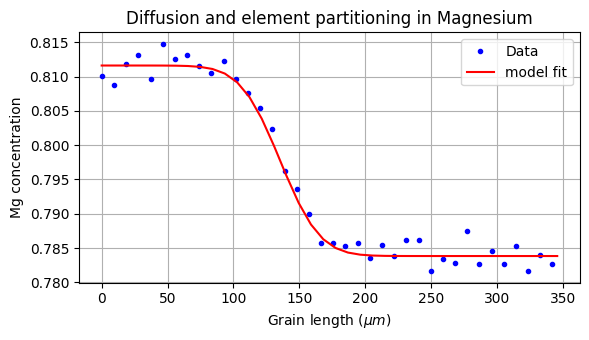

In [26]:
# Load the data
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/Data_files/PS3_Ol6a.csv', delimiter="\t", skiprows=8)
Dist = DATA[5:, 0]-46           # Length of the grain in microns
X_Fo = DATA[5:, 1]/100              # Olivine concentration

# Constants and parameters
L_grain1 = 143                  # length of the grain 1
L_grain2 = 355-143              # length of the grain 2
dt = 5                       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))     # spatial step size

# Diffusion coefficient calculation
T = 1083                        # Temperature in Celsius
P = 2e8                         # Pressure in Pascal
f_O2 = 10**(-9.02292)*1e5       # Oxygen fugacity in pascal
X_Fe = 0.2                      # Iron concentration
Diff = get_Diff_c(T, P, f_O2, X_Fe) *(3600/1e-12)               # Calculating the diffusion coefficient along c axiis
# Diff = Diff_traverse(Diff, 71.1, 49.2, 46.8)                    # Calculating the diffusion coefficient along traverse axis
print('Diffusion coefficient:', np.round(Diff, 6), 'microns^2/hr or {:.4e}'.format(Diff*1e-12/3600), 'm^2/s')
tol = 1e-6                      # tolerance for the minimization function

# Source term
def source_term(x, t):
    return 0

########################################### X_Fo ###########################################

def init_X_Fo_left(X_Fo):
    # Initial condition for at the left side of the Olivine data
    return np.average(X_Fo[:10])

def init_X_Fo_right(X_Fo):
    # Initial condition for at the right side of the Olivine data
    return np.average(X_Fo[-10:-1])

def func_Fo(t_max):
    # Function to calculate the root mean square error for the Olivine data
    solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, 
                                                                    init_X_Fo_left, init_X_Fo_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    # Calculate Root Mean Square Error
    rmse = np.sqrt(np.sum(((X_Fo - solution_Fo[:, -1])**2))/len(X_Fo))
    return rmse

print('\nCalculating best fit for t_max...')
t_max = find_min_solution(func_Fo, 10, 50000, tol=tol)
print('Total time:', np.round(t_max, 4), 'hours or',np.round(t_max/24, 4), 'days')
print('Root mean square error:', func_Fo(t_max))
print()

# Calculate the diffusion equation solution
solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, init_X_Fo_left, init_X_Fo_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Fo, X_Fo, Dist)
plt.show()


# Ol6b data  

Diffusion coefficient: 0.222751 microns^2/hr or 6.1875e-17 m^2/s

Calculating best fit for t_max...
Total time: 2185.0 hours or 91.0417 days
Root mean square error: 0.004890547581900504



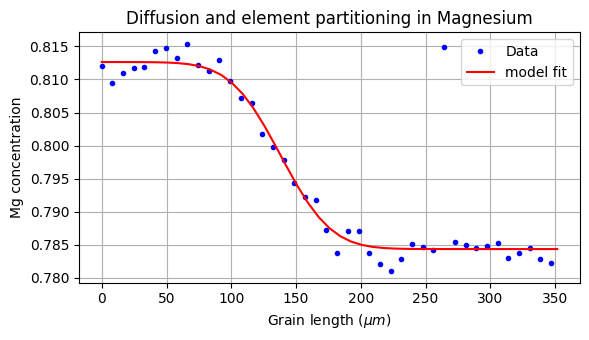

In [4]:
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/Data_files/PS3_Ol6b.csv', delimiter="\t", skiprows=8)
Dist = DATA[7:, 0]-58           # Length of the grain in microns
X_Fo = DATA[7:, 1]/100              # Olivine concentration

# Constants and parameters
L_grain1 = 143                  # length of the grain 1
L_grain2 = 360-143              # length of the grain 2
dt = 5                       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))     # spatial step size

# Diffusion coefficient calculation
# Diffusion coefficient calculation
T = 1083                        # Temperature in Celsius
P = 2e8                         # Pressure in Pascal
f_O2 = 10**(-9.02292)*1e5       # Oxygen fugacity in pascal
X_Fe = 0.2                      # Iron concentration
Diff = get_Diff_c(T, P, f_O2, X_Fe) *(3600/1e-12)               # Calculating the diffusion coefficient along c axiis
# Diff = Diff_traverse(Diff, 59.7, 42.2, 63.7)                    # Calculating the diffusion coefficient along traverse axis
print('Diffusion coefficient:', np.round(Diff, 6), 'microns^2/hr or {:.4e}'.format(Diff*1e-12/3600), 'm^2/s')
tol = 1e-6                      # tolerance for the minimization function

# Source term
def source_term(x, t):
    return 0

########################################### X_Fo ###########################################

def init_X_Fo_left(X_Fo):
    # Initial condition for at the left side of the Olivine data
    return np.average(X_Fo[:10])

def init_X_Fo_right(X_Fe):
    # Initial condition for at the right side of the Olivine data
    return np.average(X_Fo[-10:-1])

def func_Fo(t_max):
    # Function to calculate the root mean square error for the Olivine data
    solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, 
                                                                    init_X_Fo_left, init_X_Fo_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    # Calculate Root Mean Square Error
    rmse = np.sqrt(np.sum(((X_Fo - solution_Fo[:, -1])**2))/len(X_Fo))
    return rmse

print('\nCalculating best fit for t_max...')
t_max = find_min_solution(func_Fo, 10, 50000, tol=tol)
print('Total time:', np.round(t_max, 4), 'hours or',np.round(t_max/24, 4), 'days')
print('Root mean square error:', func_Fo(t_max))
print()

# Calculate the diffusion equation solution
solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, init_X_Fo_left, init_X_Fo_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Fo, X_Fo, Dist)
plt.show()


# San Pedro data

Diffusion coefficient: 0.152494 microns^2/hr or 4.2359e-17 m^2/s

Calculating best fit for t_max...
Total time: 1370.0 hours or 57.0833 days
Root mean square error: 0.001201843514050378



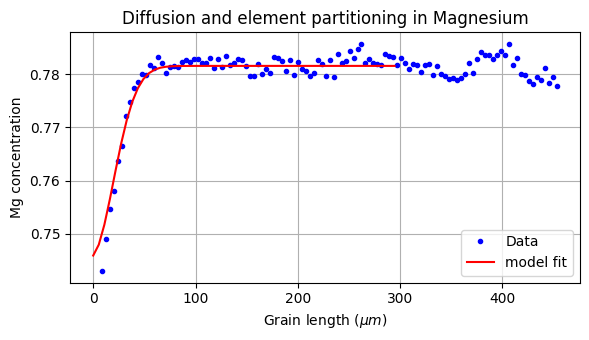

In [24]:
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/Data_files/PS3_SanPedro.csv', delimiter="\t", skiprows=9)
Dist = DATA[:55, 0]-30            # Length of the grain in microns
X_Fo = DATA[:55, 1]/100               # Olivine concentration

# Constants and parameters
L_grain1 = 21                   # length of the grain 1
L_grain2 = 300-21               # length of the grain 2
dt = 5                       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))        # spatial step size

# Diffusion coefficient calculation
# Diffusion coefficient calculation
T = 1083                        # Temperature in Celsius
P = 2e8                         # Pressure in Pascal
f_O2 = 10**(-10.37033)*1e5       # Oxygen fugacity in pascal
X_Fe = 0.22                      # Iron concentration
Diff = get_Diff_c(T, P, f_O2, X_Fe) *(3600/1e-12)               # Calculating the diffusion coefficient along c axiis
# Diff = Diff_traverse(Diff, 30.8, 65.2, 73)                    # Calculating the diffusion coefficient along traverse axis
print('Diffusion coefficient:', np.round(Diff, 6), 'microns^2/hr or {:.4e}'.format(Diff*1e-12/3600), 'm^2/s')
tol = 1e-6                      # tolerance for the minimization function

# Source term
def source_term(x, t):
    return 0

########################################### X_Fo ###########################################

def init_X_Fo_left(X_Fo):
    # Initial condition for at the left side of the Olivine data
    return 0.72#X_Fo[0]

def init_X_Fo_right(X_Fe):
    # Initial condition for at the right side of the Olivine data
    return np.average(X_Fo[-30:-1])

def func_Fo(t_max):
    # Function to calculate the root mean square error for the Olivine data
    solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, 
                                                                    init_X_Fo_left, init_X_Fo_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    # Calculate Root Mean Square Error
    rmse = np.sqrt(np.sum(((X_Fo - solution_Fo[:, -1])**2))/len(X_Fo))
    return rmse

print('\nCalculating best fit for t_max...')
t_max = find_min_solution(func_Fo, 10, 50000, tol=tol)
print('Total time:', np.round(t_max, 4), 'hours or',np.round(t_max/24, 4), 'days')
print('Root mean square error:', func_Fo(t_max))
print()

# Calculate the diffusion equation solution
solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, init_X_Fo_left, init_X_Fo_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Fo, DATA[:, 1]/100, DATA[:, 0]-30)
plt.show()
